In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")


In [51]:
pip install pandas matplotlib statsmodels pmdarima openpyxl


Note: you may need to restart the kernel to use updated packages.


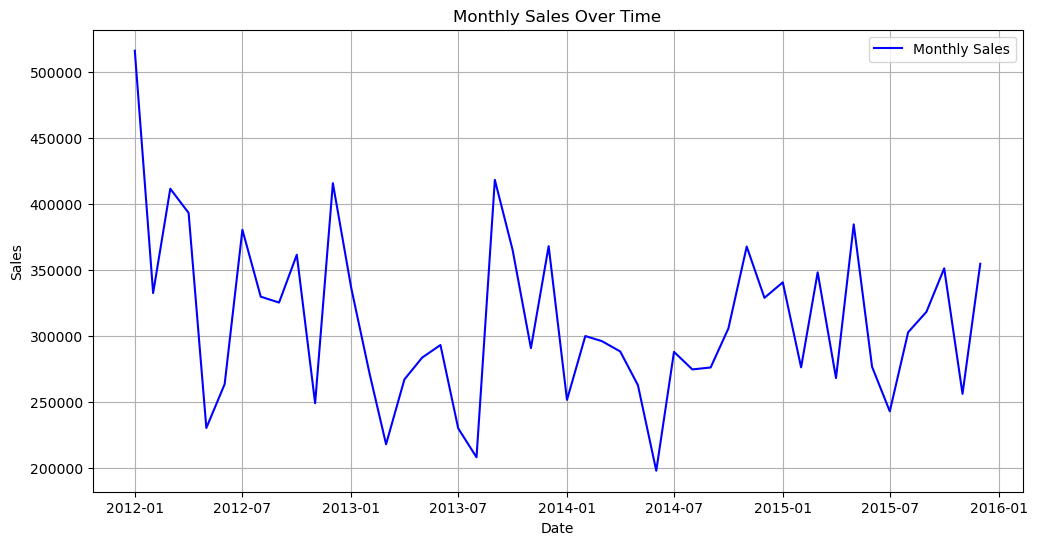

In [53]:
# Load the dataset
data = pd.read_excel(r"C:\Users\sadaa\Downloads\walmart Data.xlsx")

# Convert "Order Date" to datetime and aggregate sales by month
data['Order Date'] = pd.to_datetime(data['Order Date'])
monthly_sales = data.groupby(data['Order Date'].dt.to_period('M')).sum(numeric_only=True)['Sales']
monthly_sales = monthly_sales.to_timestamp()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [55]:
auto_model = auto_arima(monthly_sales, seasonal=True, m=12, trace=True, suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1200.925, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1206.034, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1208.096, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1354.229, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1202.925, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1202.908, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1204.908, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1204.039, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1206.104, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1207.085, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.197 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:           

In [57]:
model = SARIMAX(monthly_sales, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12))
sarima_model = model.fit(disp=False)
print(sarima_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -445.234
Date:                            Thu, 23 Jan 2025   AIC                            900.467
Time:                                    13:20:15   BIC                            908.244
Sample:                                01-01-2012   HQIC                           903.152
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2980      0.427      0.698      0.485      -0.539       1.135
ma.L1         -0.6450      0.301   

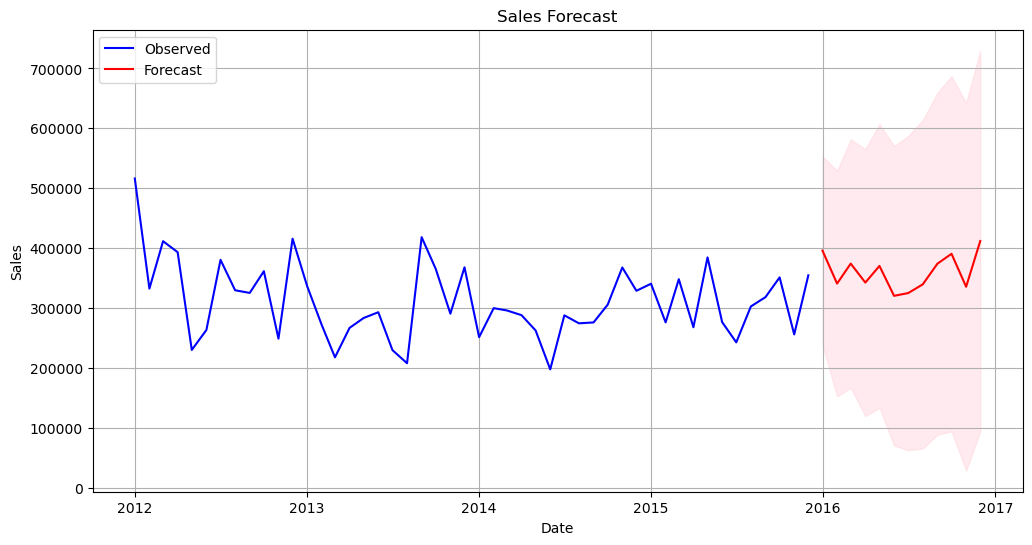

In [59]:
forecast = sarima_model.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=12, freq='M')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


In [17]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print("train size:", train.shape)
print("Test Size:", test.shape)


train size: (6719, 24)
Test Size: (1680, 24)


Mean Absolute Error (MAE): 41328.576633973455
Mean Squared Error (MSE): 2699487428.9134865
Root Mean Squared Error (RMSE): 51956.59177538002


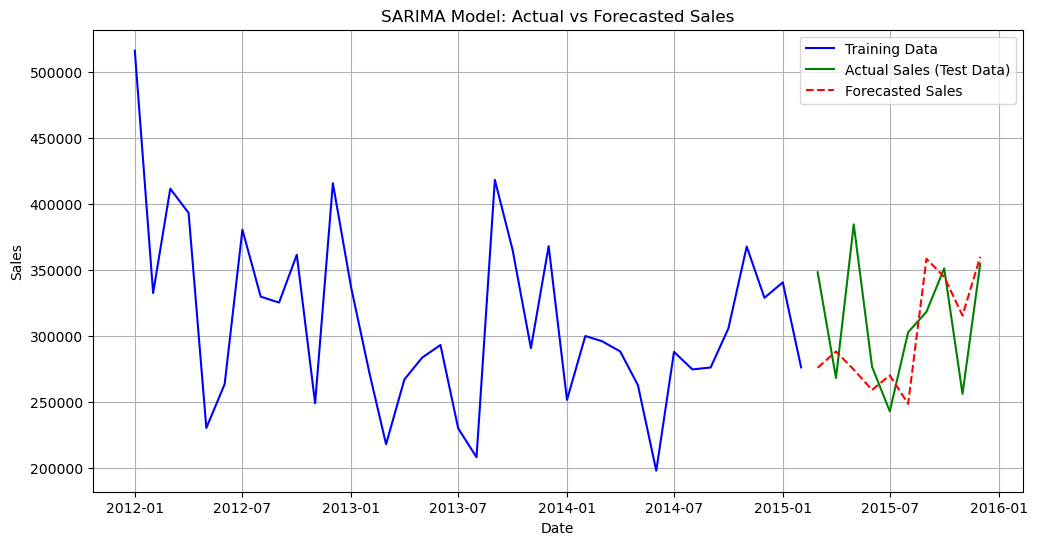

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load and preprocess the data
data = pd.read_excel(r"C:\Users\sadaa\Downloads\walmart Data.xlsx")
data['Order Date'] = pd.to_datetime(data['Order Date'])
monthly_sales = data.groupby(data['Order Date'].dt.to_period("M"))['Sales'].sum().to_timestamp()

# Split the data (80% training, 20% testing)
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

# SARIMA model training
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Forecasting
forecast = sarima_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot Actual vs Forecasted Sales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Sales (Test Data)', color='green')
plt.plot(test.index, forecast, label='Forecasted Sales', color='red', linestyle='dashed')
plt.title('SARIMA Model: Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


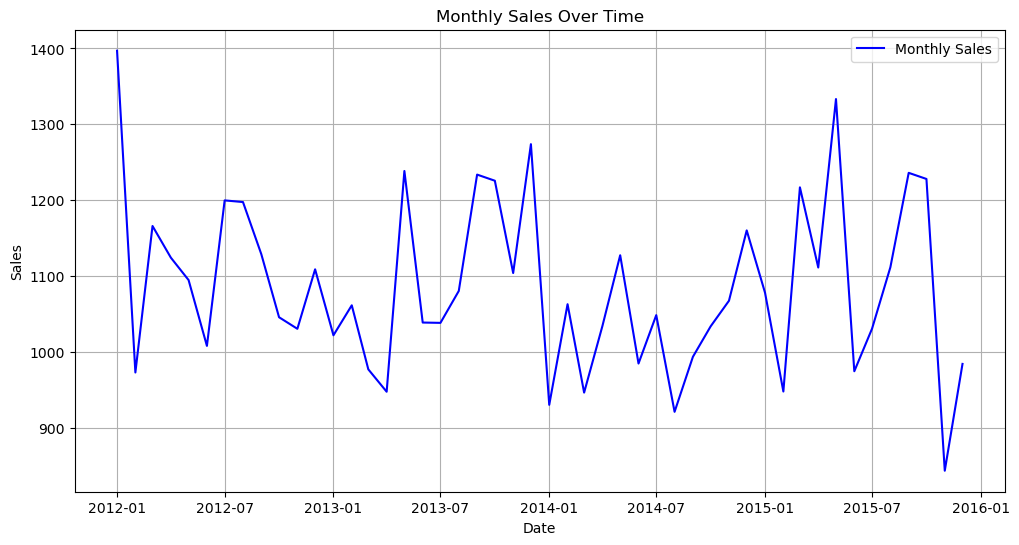

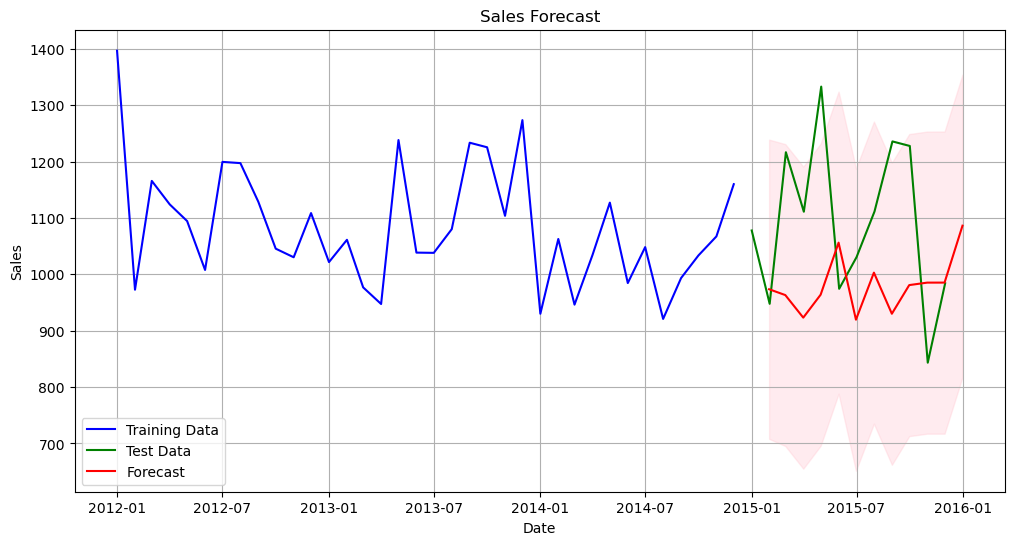

Mean Absolute Error (MAE): 153.63256107754535
Mean Squared Error (MSE): 32249.046173539846
Root Mean Squared Error (RMSE): 179.58019426857697


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
data = pd.read_csv("C:\MyProjects\EDA_data.csv")

# Convert "Order Date" to datetime and aggregate sales by month
data['Order Date'] = pd.to_datetime(data['Order Date'])
monthly_sales = data.groupby(data['Order Date'].dt.to_period('M')).sum(numeric_only=True)['Log Sales']
monthly_sales = monthly_sales.to_timestamp()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Split data into training and testing sets
train = monthly_sales[:-12]  # Use all but the last 12 months for training
test = monthly_sales[-12:]  # Use the last 12 months for testing

# Fit the SARIMAX model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = sarima_model.fit()

# Step 1: Forecast using the model (get_forecast)
forecast_steps = 12  # Forecast the next 12 months
forecast_result = result.get_forecast(steps=forecast_steps)

# Step 2: Get forecasted values (predicted_mean) and confidence intervals
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Step 3: Create a date range for the forecast period
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Step 4: Plotting the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0],  # Lower bound of confidence interval
                 conf_int.iloc[:, 1],  # Upper bound of confidence interval
                 color='pink', alpha=0.3)

plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Step 5: Evaluation metrics
# Align test and forecast_values for comparison
mae = mean_absolute_error(test, forecast_values)
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
